In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import zipfile

zip_path = "/content/drive/MyDrive/processed_dataset.zip"
extract_path = "/content/drive/MyDrive/processed_dataset"   # final extracted folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:",extract_path)

✅ Dataset extracted to: /content/drive/MyDrive/processed_dataset


In [8]:
data_dir = "/content/drive/MyDrive/processed_dataset/processed_dataset/dataset"

In [9]:
# 2/9 - Imports & config
import os, random, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pywt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

# Paths & hyperparams (edit if you want)
DATA_DIR = "/content/drive/MyDrive/processed_dataset/processed_dataset/dataset"   # <- after unzip
SAVE_PATH = os.path.join(DATA_DIR, "best_wavelet_resnet50.pt")
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 20
LR = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 6
WAVELET_NAME = "db2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = True if device.type == "cuda" else False

print("Device:", device)
print("DATA_DIR:", DATA_DIR)
print("SAVE_PATH:", SAVE_PATH)

# quick folder check (expects folders: cataract, diabetic_retinopathy, glaucoma, normal)
for cls in ["cataract","diabetic_retinopathy","glaucoma","normal"]:
    p = Path(DATA_DIR)/cls
    print(cls, "exists:", p.exists(), "count:", len(list(p.glob("*"))) if p.exists() else 0)

Device: cuda
DATA_DIR: /content/drive/MyDrive/processed_dataset/processed_dataset/dataset
SAVE_PATH: /content/drive/MyDrive/processed_dataset/processed_dataset/dataset/best_wavelet_resnet50.pt
cataract exists: True count: 1035
diabetic_retinopathy exists: True count: 1036
glaucoma exists: True count: 1007
normal exists: True count: 1074


In [12]:
# 3/9 - Transforms, stratified split func, WaveletImageFolder, DataLoaders

import torch, cv2, pywt, numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit

# 🔹 Make sure these are already defined earlier
# DATA_DIR = "/content/drive/MyDrive/processed_dataset/processed_dataset/dataset"
# IMG_SIZE = 224
# SEED = 42
# WAVELET_NAME = "db2"
# BATCH_SIZE = 16
# pin_memory = True if torch.cuda.is_available() else False

# ImageNet normalization (applied only to RGB channels)
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

# PIL transforms for augmentation (applied before wavelet)
train_pil_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
])

val_pil_tf = transforms.Resize((IMG_SIZE, IMG_SIZE))

# 🔹 Base ImageFolder (no transforms) for splitting
base_ds = datasets.ImageFolder(DATA_DIR)
print("Classes:", base_ds.classes)

def stratified_split(imagefolder, test_size=0.15, val_size=0.15, seed=SEED):
    """Split dataset indices into stratified Train / Val / Test"""
    targets = [s[1] for s in imagefolder.samples]
    idx = np.arange(len(targets))

    # First split train+val vs test
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    trainval_idx, test_idx = next(sss1.split(idx, targets))

    # Then split train vs val
    trainval_targets = np.array(targets)[trainval_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=seed)
    train_idx, val_idx = next(sss2.split(trainval_idx, trainval_targets))

    return train_idx, val_idx, test_idx

# 🔹 Generate indices
train_idx, val_idx, test_idx = stratified_split(base_ds)
print(f"Train={len(train_idx)} Val={len(val_idx)} Test={len(test_idx)}")

class WaveletImageFolder(Dataset):
    """ImageFolder-like dataset that returns a 6xHxW tensor: [RGB (3), Wavelet channels (3)]"""
    def __init__(self, imagefolder, indices, pil_transform, wavelet="db2"):
        self.imagefolder = imagefolder
        self.indices = list(indices)
        self.pil_transform = pil_transform
        self.wavelet = wavelet
        self.classes = imagefolder.classes

    def __len__(self):
        return len(self.indices)

    def _compute_wavelet(self, img_rgb_np):
        # Take green channel for wavelet
        green = img_rgb_np[:, :, 1].astype(np.float32)
        cA, (cH, cV, cD) = pywt.dwt2(green, self.wavelet)
        H, W = green.shape
        up = lambda x: cv2.resize(x, (W, H), interpolation=cv2.INTER_CUBIC)
        cH, cV, cD = up(cH), up(cV), up(cD)
        stack = np.stack([cH, cV, cD], axis=-1)
        # normalize to 0..1
        stack = (stack - stack.min()) / (stack.max() - stack.min() + 1e-8)
        return stack

    def __getitem__(self, i):
        path, label = self.imagefolder.samples[self.indices[i]]
        pil = self.imagefolder.loader(path)  # PIL image
        pil_aug = self.pil_transform(pil)
        img_np = np.array(pil_aug)

        # If grayscale -> convert to 3 channels
        if img_np.ndim == 2:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
        if img_np.shape[2] == 4:  # RGBA -> RGB
            img_np = img_np[:, :, :3]

        wave = self._compute_wavelet(img_np)

        rgb_t  = torch.from_numpy(img_np).permute(2,0,1).float() / 255.0
        wave_t = torch.from_numpy(wave).permute(2,0,1).float()
        x = torch.cat([rgb_t, wave_t], dim=0)   # 6xHxW

        # normalize RGB channels
        x[:3] = (x[:3] - IMAGENET_MEAN) / IMAGENET_STD

        return x, label, path

# 🔹 Create datasets + loaders
train_ds = WaveletImageFolder(base_ds, train_idx, train_pil_tf, wavelet=WAVELET_NAME)
val_ds   = WaveletImageFolder(base_ds, val_idx,   val_pil_tf,   wavelet=WAVELET_NAME)
test_ds  = WaveletImageFolder(base_ds, test_idx,  val_pil_tf,   wavelet=WAVELET_NAME)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=pin_memory)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin_memory)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin_memory)

print("Dataset sizes -> Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Train=2906 Val=623 Test=623
Dataset sizes -> Train: 2906 Val: 623 Test: 623


In [15]:
# 4/9 - Build ResNet50 that accepts 6-channel input and final fc for num_classes

import torch.nn as nn
from torchvision import models # Import models here

def build_resnet50_6ch(num_classes, pretrained=True):
    """
    Builds a ResNet50 where the first conv accepts 6 channels (RGB + 3 wavelet channels).
    Initializes the extra channels with the mean of the pretrained RGB weights.
    """
    # Try new torchvision weights API, fallback to older if necessary
    try:
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
    except Exception:
        resnet = models.resnet50(pretrained=pretrained)

    old_conv = resnet.conv1
    # Replace conv1 with 6-input channel conv
    resnet.conv1 = nn.Conv2d(6, old_conv.out_channels, kernel_size=7, stride=2, padding=3, bias=False)

    # Initialize new conv weights: copy RGB and set wavelet channels to mean RGB
    with torch.no_grad():
        # copy RGB weights
        resnet.conv1.weight[:, :3] = old_conv.weight
        # mean across input channels (RGB) -> shape (out_ch,1,7,7)
        mean_rgb = old_conv.weight.mean(dim=1, keepdim=True)
        # set the remaining 3 channels to mean_rgb
        resnet.conv1.weight[:, 3:] = mean_rgb

    # Replace final fc to match num_classes
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
    return resnet

# Instantiate model
num_classes = len(train_ds.classes)
model = build_resnet50_6ch(num_classes=num_classes, pretrained=True)

# Move to device and use channels-last memory format for a small speedup on GPU
model = model.to(device).to(memory_format=torch.channels_last)
print("Model built. Num classes:", num_classes)

Model built. Num classes: 4


In [16]:
# 5/9 - Loss, optimizer, scheduler, class weights

# Compute class weights to handle imbalance
def compute_class_weights(imagefolder, indices):
    targets = np.array([imagefolder.samples[i][1] for i in indices])
    counts = np.bincount(targets, minlength=len(imagefolder.classes))
    inv = 1.0 / (counts + 1e-6)
    weights = inv / inv.sum() * len(imagefolder.classes)
    return torch.tensor(weights, dtype=torch.float32)

class_weights = compute_class_weights(base_ds, train_idx).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Mixed precision scaler for faster GPU training
scaler = torch.amp.GradScaler(enabled=(device.type=="cuda"))

print("Criterion, optimizer, scheduler, scaler set.")

Criterion, optimizer, scheduler, scaler set.


Epoch 01/20 | train_loss=0.5339 acc=0.8052 | val_loss=0.3329 acc=0.8764 | time=53.1s
  -> Saved: /content/drive/MyDrive/best_wavelet_resnet50.pt
Epoch 02/20 | train_loss=0.3382 acc=0.8747 | val_loss=0.2758 acc=0.8860 | time=42.7s
  -> Saved: /content/drive/MyDrive/best_wavelet_resnet50.pt
Epoch 03/20 | train_loss=0.2834 acc=0.8985 | val_loss=0.2150 acc=0.9230 | time=44.7s
  -> Saved: /content/drive/MyDrive/best_wavelet_resnet50.pt
Epoch 04/20 | train_loss=0.2319 acc=0.9195 | val_loss=0.2584 acc=0.8973 | time=46.2s
Epoch 05/20 | train_loss=0.2139 acc=0.9288 | val_loss=0.1949 acc=0.9342 | time=41.5s
  -> Saved: /content/drive/MyDrive/best_wavelet_resnet50.pt
Epoch 06/20 | train_loss=0.1950 acc=0.9363 | val_loss=0.1991 acc=0.9374 | time=44.0s
Epoch 07/20 | train_loss=0.1651 acc=0.9415 | val_loss=0.2232 acc=0.9197 | time=41.8s
Epoch 08/20 | train_loss=0.1392 acc=0.9504 | val_loss=0.1855 acc=0.9294 | time=41.7s
  -> Saved: /content/drive/MyDrive/best_wavelet_resnet50.pt
Epoch 09/20 | train_

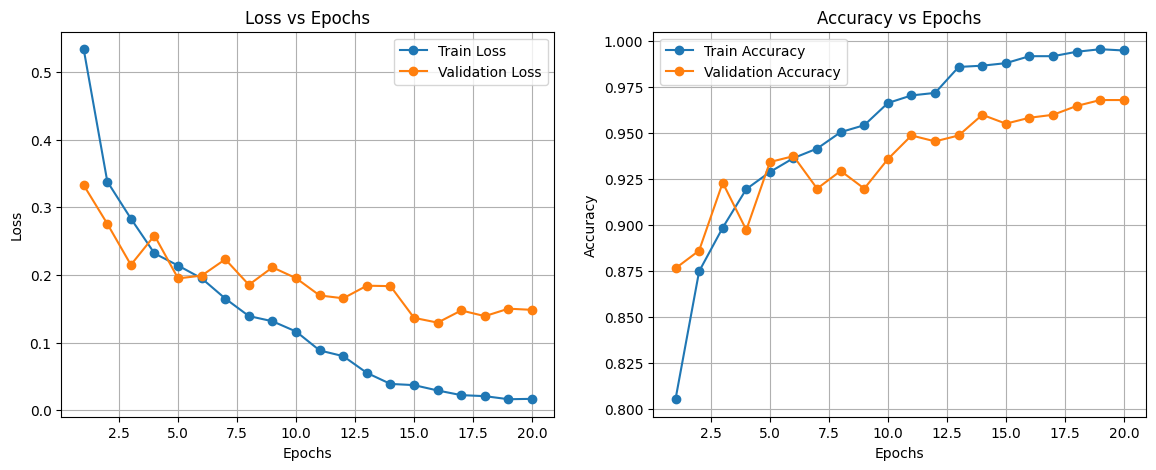

<Figure size 640x480 with 0 Axes>

In [17]:
from pathlib import Path
import time
import torch
import matplotlib.pyplot as plt

# ✅ Save directly to Google Drive
best_val_loss = float("inf")
best_ckpt = Path("/content/drive/MyDrive/best_wavelet_resnet50.pt")
early_counter = 0

# Lists to store metrics for plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []


def run_one_epoch(model, loader, train=True):
    model.train(train)
    total_loss, total_correct, total = 0.0, 0, 0

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            out = model(x)
            loss = criterion(out, y)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total


# 🔹 Training loop
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss, train_acc = run_one_epoch(model, train_loader, train=True)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    with torch.no_grad():
        val_loss, val_acc = run_one_epoch(model, val_loader, train=False)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"time={time.time()-t0:.1f}s")

    # ✅ Early stopping + save checkpoint in Google Drive
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        early_counter = 0
        torch.save({
            "model": model.state_dict(),
            "classes": train_ds.classes,
            "img_size": IMG_SIZE,
            "wavelet": WAVELET_NAME
        }, best_ckpt)
        print("  -> Saved:", best_ckpt)
    else:
        early_counter += 1
        if early_counter >= PATIENCE:
            print("Early stopping triggered.")
            break


# 🔹 Plot Loss & Accuracy
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_accs, label="Validation Accuracy", marker='o')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.show()

# ✅ Save the plot in Drive
plt.savefig("/content/drive/MyDrive/wavelet_resnet50_training_plot.png")

Test Accuracy: 0.9614767255216693
                      precision    recall  f1-score   support

            cataract       0.96      0.99      0.97       155
diabetic_retinopathy       1.00      1.00      1.00       156
            glaucoma       0.91      0.97      0.94       151
              normal       0.98      0.89      0.93       161

            accuracy                           0.96       623
           macro avg       0.96      0.96      0.96       623
        weighted avg       0.96      0.96      0.96       623



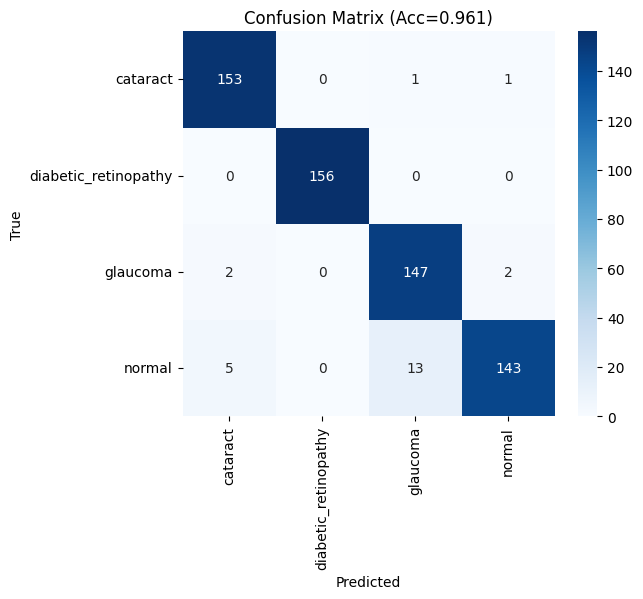

In [18]:
# 7/9 - Load Best Checkpoint & Evaluate on Test Set

# Load the best saved model
ckpt = torch.load(best_ckpt, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

all_t, all_p = [], []

with torch.no_grad():
    for x, y, _ in test_loader:
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)
        out = model(x)

        all_t.extend(y.cpu().numpy())
        all_p.extend(out.argmax(1).cpu().numpy())

# Accuracy and classification report
acc = accuracy_score(all_t, all_p)
print("Test Accuracy:", acc)
print(classification_report(all_t, all_p, target_names=train_ds.classes))

# Confusion matrix
cm = confusion_matrix(all_t, all_p)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc={acc:.3f})")
plt.show()

In [19]:
!pip install grad-cam==1.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38340 sha256=c4980b137f97a629145bce74ef4b4616e2395243c6abbe1efe61fe54ac52845b
  Stored in directory: /root/.cache/pip/wheels/02/26/f1/92ac7f7699f6f0849e03e212b8b0bb8d2c3d7b2723aa474b22
Successfully built grad-cam


In [21]:
import torch
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import cv2
import pywt

# 1️⃣ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2️⃣ ImageNet normalization
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

# 3️⃣ Load checkpoint
BEST_CKPT_PATH = "/content/drive/MyDrive/best_wavelet_resnet50.pt"  # change if needed
ckpt = torch.load(BEST_CKPT_PATH, map_location=device)

# 4️⃣ Load model
import torch.nn as nn
from torchvision import models

num_classes = len(ckpt["classes"])
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
old_conv = resnet.conv1
resnet.conv1 = nn.Conv2d(6, old_conv.out_channels, kernel_size=7, stride=2, padding=3, bias=False)
with torch.no_grad():
    resnet.conv1.weight[:, :3] = old_conv.weight
    mean_rgb = old_conv.weight.mean(dim=1, keepdim=True)
    resnet.conv1.weight[:, 3:] = mean_rgb
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(ckpt["model"])
resnet = resnet.to(device).eval()

classes = ckpt["classes"]
wavelet_name = ckpt["wavelet"]
img_size = ckpt["img_size"]

# 5️⃣ Prediction function
def predict_image(img_path, model, classes, wavelet=wavelet_name):
    pil = Image.open(img_path).convert("RGB")
    # Resize
    pil = pil.resize((img_size, img_size))
    img_np = np.array(pil)

    # Wavelet
    green = img_np[:, :, 1].astype(np.float32)
    cA, (cH, cV, cD) = pywt.dwt2(green, wavelet)
    H, W = green.shape
    up = lambda x: cv2.resize(x, (W,H), interpolation=cv2.INTER_CUBIC)
    cH, cV, cD = up(cH), up(cV), up(cD)
    wave = np.stack([cH, cV, cD], axis=-1)
    wave = (wave - wave.min()) / (wave.max()-wave.min()+1e-8)

    rgb_t  = torch.from_numpy(img_np).permute(2,0,1).float()/255.0
    wave_t = torch.from_numpy(wave).permute(2,0,1).float()
    x = torch.cat([rgb_t, wave_t], dim=0).unsqueeze(0)  # 1x6xHxW
    x[:,:3] = (x[:,:3] - IMAGENET_MEAN) / IMAGENET_STD
    x = x.to(device)

    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)
        return classes[pred_idx], probs[pred_idx]

# 6️⃣ Predict your image
img_path = "/content/drive/MyDrive/processed_dataset/processed_dataset/dataset/diabetic_retinopathy/0083ee8054ee.png"
pred_class, pred_prob = predict_image(img_path, resnet, classes)
print(f"Prediction: {pred_class} (Confidence: {pred_prob:.4f})")

Prediction: diabetic_retinopathy (Confidence: 1.0000)


In [22]:
img_path = "/content/drive/MyDrive/processed_dataset/processed_dataset/dataset/glaucoma/1209_right.jpg"
pred_class, pred_prob = predict_image(img_path, resnet, classes)
print(f"Prediction: {pred_class} (Confidence: {pred_prob:.4f})")

Prediction: glaucoma (Confidence: 1.0000)


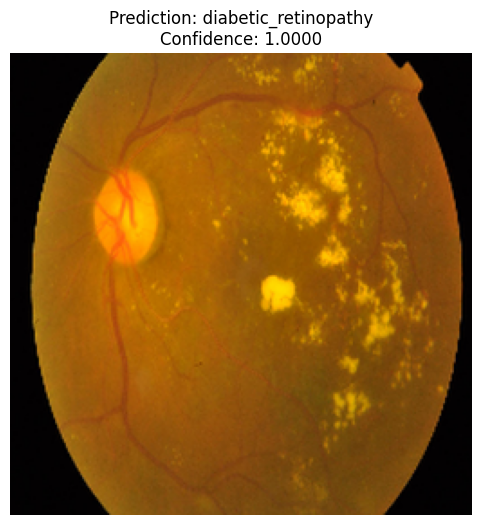

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show(img_path, model, classes):
    # Predict
    pred_class, pred_prob = predict_image(img_path, model, classes)

    # Load image
    img = Image.open(img_path).convert("RGB")

    # Display
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {pred_class}\nConfidence: {pred_prob:.4f}")
    plt.show()

# Example usage
img_path = "/content/drive/MyDrive/processed_dataset/processed_dataset/dataset/diabetic_retinopathy/0104b032c141.png"

predict_and_show(img_path, resnet, classes)